In [2]:
!pip install transformers datasets torch scikit-learn pandas matplotlib seaborn -q

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModel,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# GPU 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
from google.colab import drive
drive.mount('/content/drive')

#첫번째 열을 index로
df_annotated = pd.read_csv('/content/drive/MyDrive/annotated_sampled_fn.csv', index_col = 0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df_annotated.head()

,app_id,primary_genre,sentence,top_aspect,sub_aspect,sentiment
0,1086940,NaN,매일 새벽4시까지 하도록 하는 미친 게임,GAMEPLAY,GP_FUN,positive
1,1086940,NaN,150 시간만에 1회차 클리어햇다 미친 게임 갓 게임 진짜 내인생게임이다 2회차는 ...,GAMEPLAY,GP_CONTENT,positive
2,1086940,NaN,나는 500시간 넘게 플레이했지만 아직 엔딩을 한번밖에 보지 않았다.,GAMEPLAY,GP_CONTENT,positive
3,1086940,NaN,내 이쉐키야 살려줬더니 은혜를 원수로갚냐 한량쉐키야,OTHER,OTHER,neutral
4,1086940,NaN,말이 필요없는 명작 벌써 1년이 지났는데도 또 새로운 패치로 대규모 업데이트를 무료...,GAMEPLAY,GP_CONTENT,positive


In [5]:
# 필요한 컬럼만 선택
df_annotated = df_annotated[['app_id', 'sentence', 'top_aspect', 'sub_aspect', 'sentiment']].copy()

# other 제거
df_clean = df_annotated[df_annotated['top_aspect'] != 'OTHER'].copy()

print(df_clean['app_id'].value_counts())

app_id
1086940    2571
1091500    1883
413150     1036
578080      802
730         342
289070      337
1449850     305
227300      287
394360      237
3405690     173
489830      170
1222670     169
3450310     162
438100      157
813780      149
570         144
431960       87
Name: count, dtype: int64


In [6]:
#10개 미만 sub_aspect 삭제
sub_counts = df_clean['sub_aspect'].value_counts()
valid_sub_aspects = sub_counts[sub_counts >= 10].index
df_clean = df_clean[df_clean['sub_aspect'].isin(valid_sub_aspects)].copy()

In [7]:
print(df_clean['top_aspect'].value_counts())
print('\n', df_clean['sub_aspect'].value_counts())

top_aspect
GAMEPLAY               5163
TECHNICAL              1551
SYSTEM_BALANCE          706
MULTI_COMMUNITY         665
ECONOMY_PROGRESSION     458
AUDIOVISUAL             434
Name: count, dtype: int64

 sub_aspect
GP_FUN                3244
GP_CONTENT            1742
TECH_BUG               894
ECO_MONETIZATION       399
SYS_DIFFICULTY         368
TECH_PERFORMANCE       304
MULTI_FAIRNESS         290
MULTI_SOCIAL           278
AV_GRAPHICS            259
TECH_LOCALIZATION      204
SYS_RULE               193
GP_COMBAT              130
AV_SOUND               106
SYS_BALANCE             86
TECH_NET                81
AV_UI_FEEL              69
TECH_ANTICHEAT          68
SYS_AI                  61
COMMUNITY_BEHAVIOR      55
ECO_PROGRESSION         45
GP_CONTROL              45
MULTI_MATCHING          42
ECO_REWARD              14
Name: count, dtype: int64


In [8]:
# 라벨인코딩
from sklearn.preprocessing import LabelEncoder

le_top = LabelEncoder()
le_sub = LabelEncoder()
le_sent = LabelEncoder()

df_clean['top_label'] = le_top.fit_transform(df_clean['top_aspect'])
df_clean['sub_label'] = le_sub.fit_transform(df_clean['sub_aspect'])
df_clean['sent_label'] = le_sent.fit_transform(df_clean['sentiment'])

# 매핑 저장
top_mapping = dict(enumerate(le_top.classes_))
sub_mapping = dict(enumerate(le_sub.classes_))
sent_mapping = dict(enumerate(le_sent.classes_))

print("\n=== 라벨 매핑 ===")
print(f"Top aspects: {len(top_mapping)}개")
print(top_mapping)
print(f"\nSub aspects: {len(sub_mapping)}개")
print(sub_mapping)
print(f"\nSentiment: {sent_mapping}")

# 클래스 개수
num_top = len(top_mapping)
num_sub = len(sub_mapping)
num_sent = len(sent_mapping)

print(f"\n분류 클래스 수: Top={num_top}, Sub={num_sub}, Sent={num_sent}")


=== 라벨 매핑 ===
Top aspects: 6개
{0: 'AUDIOVISUAL', 1: 'ECONOMY_PROGRESSION', 2: 'GAMEPLAY', 3: 'MULTI_COMMUNITY', 4: 'SYSTEM_BALANCE', 5: 'TECHNICAL'}

Sub aspects: 23개
{0: 'AV_GRAPHICS', 1: 'AV_SOUND', 2: 'AV_UI_FEEL', 3: 'COMMUNITY_BEHAVIOR', 4: 'ECO_MONETIZATION', 5: 'ECO_PROGRESSION', 6: 'ECO_REWARD', 7: 'GP_COMBAT', 8: 'GP_CONTENT', 9: 'GP_CONTROL', 10: 'GP_FUN', 11: 'MULTI_FAIRNESS', 12: 'MULTI_MATCHING', 13: 'MULTI_SOCIAL', 14: 'SYS_AI', 15: 'SYS_BALANCE', 16: 'SYS_DIFFICULTY', 17: 'SYS_RULE', 18: 'TECH_ANTICHEAT', 19: 'TECH_BUG', 20: 'TECH_LOCALIZATION', 21: 'TECH_NET', 22: 'TECH_PERFORMANCE'}

Sentiment: {0: 'negative', 1: 'neutral', 2: 'positive'}

분류 클래스 수: Top=6, Sub=23, Sent=3


In [9]:
# train/test/validation 분할

df_train, temp_df = train_test_split(
    df_clean,
    test_size=0.2,
    random_state=42,
    stratify=df_clean['top_label']
)

df_val, df_test = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    stratify=temp_df['top_label']
)

print(f"Train: {len(df_train):,}")
print(f"Valid: {len(df_val):,}")
print(f"Test: {len(df_test):,}")

# 인덱스 리셋
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


Train: 7,181
Valid: 898
Test: 898


In [10]:
# Dataset 클래스

class ReviewDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=128):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = str(self.data.iloc[idx]['sentence'])
        top_label = self.data.iloc[idx]['top_label']
        sub_label = self.data.iloc[idx]['sub_label']
        sent_label = self.data.iloc[idx]['sent_label']

        # 토크나이징
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'top_label': torch.tensor(top_label, dtype=torch.long),
            'sub_label': torch.tensor(sub_label, dtype=torch.long),
            'sent_label': torch.tensor(sent_label, dtype=torch.long)
        }

# 토크나이저 로딩 (kobert->beomi/KcELECTRA-base로 변경)
#tokenizer = AutoTokenizer.from_pretrained('skt/kobert-base-v1')
tokenizer = AutoTokenizer.from_pretrained('monologg/koelectra-base-v3-discriminator')

# Dataset 생성
dataset_train = ReviewDataset(df_train, tokenizer)
dataset_val = ReviewDataset(df_val, tokenizer)
dataset_test = ReviewDataset(df_test, tokenizer)

print("✓ Dataset 생성 완료")

tokenizer_config.json:   0%|          | 0.00/61.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/467 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

✓ Dataset 생성 완료


In [11]:
# DataLoader


BATCH_SIZE = 32

loader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

print(f"✓ DataLoader 생성 완료")
print(f"  Train batches: {len(loader_train)}")
print(f"  Valid batches: {len(loader_val)}")
print(f"  Test batches: {len(loader_test)}")

# 테스트
sample_batch = next(iter(loader_train))
print(f"\n샘플 배치 shape:")
print(f"  input_ids: {sample_batch['input_ids'].shape}")
print(f"  top_label: {sample_batch['top_label'].shape}")

✓ DataLoader 생성 완료
  Train batches: 225
  Valid batches: 29
  Test batches: 29

샘플 배치 shape:
  input_ids: torch.Size([32, 128])
  top_label: torch.Size([32])


In [12]:

import torch.nn as nn

class BaselineModel(nn.Module):
    def __init__(self, num_top, num_sub, num_sent, dropout=0.3):
        super().__init__()

        # KcELECTRA 인코더 (tokenizer와 동일한 모델로 변경, dtype 명시)
        self.encoder = AutoModel.from_pretrained('monologg/koelectra-base-v3-discriminator', dtype=torch.float32)
        hidden_size = self.encoder.config.hidden_size

        # 3개 분류 헤드
        self.top_classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_top)
        )

        self.sub_classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_sub)
        )

        self.sent_classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_sent)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        #pooled = outputs.pooler_output
        pooled = outputs.last_hidden_state[:, 0, :]
        top_logits = self.top_classifier(pooled)
        sub_logits = self.sub_classifier(pooled)
        sent_logits = self.sent_classifier(pooled)

        return top_logits, sub_logits, sent_logits

# 모델 생성
model_baseline = BaselineModel(num_top, num_sub, num_sent)
model_baseline = model_baseline.float().to(device) # Explicitly convert to float32 before moving to device

print("✓ 모델 생성 완료")
print(f"  파라미터: {sum(p.numel() for p in model_baseline.parameters()):,}")

pytorch_model.bin:   0%|          | 0.00/452M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/452M [00:00<?, ?B/s]

✓ 모델 생성 완료
  파라미터: 112,355,360


In [13]:
# 학습/평가 함수

def train_epoch(model, data_loader, optimizer, scheduler, device):
    model.train()
    losses = []

    progress_bar = tqdm(data_loader, desc='Training')

    for batch in progress_bar:
        # 데이터 이동
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        top_labels = batch['top_label'].to(device)
        sub_labels = batch['sub_label'].to(device)
        sent_labels = batch['sent_label'].to(device)

        # Forward
        top_logits, sub_logits, sent_logits = model(input_ids, attention_mask)

        # Loss 계산 (Multi-Task Learning)
        loss_fn = nn.CrossEntropyLoss()
        loss_top = loss_fn(top_logits, top_labels)
        loss_sub = loss_fn(sub_logits, sub_labels)
        loss_sent = loss_fn(sent_logits, sent_labels)

        # 총 Loss
        loss = loss_sub + loss_sent + loss_top

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        losses.append(loss.item())
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

    return np.mean(losses)


def eval_model(model, data_loader, device):
    model.eval()

    all_top_preds = []
    all_top_labels = []
    all_sub_preds = []
    all_sub_labels = []
    all_sent_preds = []
    all_sent_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # 예측
            top_logits, sub_logits, sent_logits = model(input_ids, attention_mask)

            # Argmax
            top_preds = torch.argmax(top_logits, dim=1).cpu().numpy()
            sub_preds = torch.argmax(sub_logits, dim=1).cpu().numpy()
            sent_preds = torch.argmax(sent_logits, dim=1).cpu().numpy()

            # 저장
            all_top_preds.extend(top_preds)
            all_sub_preds.extend(sub_preds)
            all_sent_preds.extend(sent_preds)

            all_top_labels.extend(batch['top_label'].numpy())
            all_sub_labels.extend(batch['sub_label'].numpy())
            all_sent_labels.extend(batch['sent_label'].numpy())

    # 정확도 계산
    top_acc = accuracy_score(all_top_labels, all_top_preds)
    sub_acc = accuracy_score(all_sub_labels, all_sub_preds)
    sent_acc = accuracy_score(all_sent_labels, all_sent_preds)

    return {
        'top_acc': top_acc,
        'sub_acc': sub_acc,
        'sent_acc': sent_acc,
        'top_preds': all_top_preds,
        'top_labels': all_top_labels
    }

## 학습

In [15]:
# 학습

# 하이퍼파라미터
EPOCHS = 10            # 5-->10 변경
LEARNING_RATE = 5e-5   #2e-5 -->5e-5 변경

# Optimizer
optimizer = AdamW(model_baseline.parameters(), lr=LEARNING_RATE)

# Learning Rate Scheduler
total_steps = len(loader_train) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

print("=" * 60)
print("Baseline 학습 시작")
print("=" * 60)
print(f"Epochs: {EPOCHS}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Total Steps: {total_steps}")
print(f"Device: {device}")
print("=" * 60)

# 학습 기록
best_val_acc = 0
history = {
    'train_loss': [],
    'val_top_acc': [],
    'val_sub_acc': [],
    'val_sent_acc': []
}

# 학습 루프
for epoch in range(EPOCHS):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"{'='*60}")

    # Train
    train_loss = train_epoch(
        model_baseline,
        loader_train,
        optimizer,
        scheduler,
        device
    )
    history['train_loss'].append(train_loss)

    # Validation
    val_metrics = eval_model(model_baseline, loader_val, device)
    history['val_top_acc'].append(val_metrics['top_acc'])
    history['val_sub_acc'].append(val_metrics['sub_acc'])
    history['val_sent_acc'].append(val_metrics['sent_acc'])

    # 결과 출력
    print(f"\n Epoch {epoch+1} 결과:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Valid Accuracy:")
    print(f"    - Top Aspect:  {val_metrics['top_acc']:.4f}")
    print(f"    - Sub Aspect:  {val_metrics['sub_acc']:.4f}")
    print(f"    - Sentiment:   {val_metrics['sent_acc']:.4f}")

    # Best model 저장
    if val_metrics['top_acc'] > best_val_acc:
        best_val_acc = val_metrics['top_acc']
        torch.save(model_baseline.state_dict(), 'baseline_best.pt')
        print(f"  ✓ Best model 저장! (Top Acc: {best_val_acc:.4f})")

print("\n" + "=" * 60)
print("학습 완료!")
print(f"Best Valid Top Accuracy: {best_val_acc:.4f}")
print("=" * 60)

Baseline 학습 시작
Epochs: 10
Batch Size: 32
Learning Rate: 5e-05
Total Steps: 2250
Device: cuda

Epoch 1/10


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]


 Epoch 1 결과:
  Train Loss: 4.0212
  Valid Accuracy:
    - Top Aspect:  0.6526
    - Sub Aspect:  0.4822
    - Sentiment:   0.7806
  ✓ Best model 저장! (Top Acc: 0.6526)

Epoch 2/10


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]


 Epoch 2 결과:
  Train Loss: 3.2137
  Valid Accuracy:
    - Top Aspect:  0.7038
    - Sub Aspect:  0.5200
    - Sentiment:   0.7628
  ✓ Best model 저장! (Top Acc: 0.7038)

Epoch 3/10


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]


 Epoch 3 결과:
  Train Loss: 2.6171
  Valid Accuracy:
    - Top Aspect:  0.6927
    - Sub Aspect:  0.5178
    - Sentiment:   0.7606

Epoch 4/10


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]


 Epoch 4 결과:
  Train Loss: 2.1627
  Valid Accuracy:
    - Top Aspect:  0.6893
    - Sub Aspect:  0.5122
    - Sentiment:   0.7739

Epoch 5/10


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]


 Epoch 5 결과:
  Train Loss: 1.7828
  Valid Accuracy:
    - Top Aspect:  0.6915
    - Sub Aspect:  0.4955
    - Sentiment:   0.7684

Epoch 6/10


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]


 Epoch 6 결과:
  Train Loss: 1.5046
  Valid Accuracy:
    - Top Aspect:  0.6782
    - Sub Aspect:  0.4955
    - Sentiment:   0.7706

Epoch 7/10


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]


 Epoch 7 결과:
  Train Loss: 1.2689
  Valid Accuracy:
    - Top Aspect:  0.6771
    - Sub Aspect:  0.4933
    - Sentiment:   0.7628

Epoch 8/10


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]


 Epoch 8 결과:
  Train Loss: 1.1107
  Valid Accuracy:
    - Top Aspect:  0.6915
    - Sub Aspect:  0.5045
    - Sentiment:   0.7561

Epoch 9/10


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]


 Epoch 9 결과:
  Train Loss: 0.9864
  Valid Accuracy:
    - Top Aspect:  0.6971
    - Sub Aspect:  0.4900
    - Sentiment:   0.7639

Epoch 10/10


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]


 Epoch 10 결과:
  Train Loss: 0.9069
  Valid Accuracy:
    - Top Aspect:  0.6837
    - Sub Aspect:  0.4889
    - Sentiment:   0.7595

학습 완료!
Best Valid Top Accuracy: 0.7038


Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]


=== Test 결과 ===
Top Aspect Accuracy: 0.6904
Sub Aspect Accuracy: 0.5111
Sentiment Accuracy: 0.7661


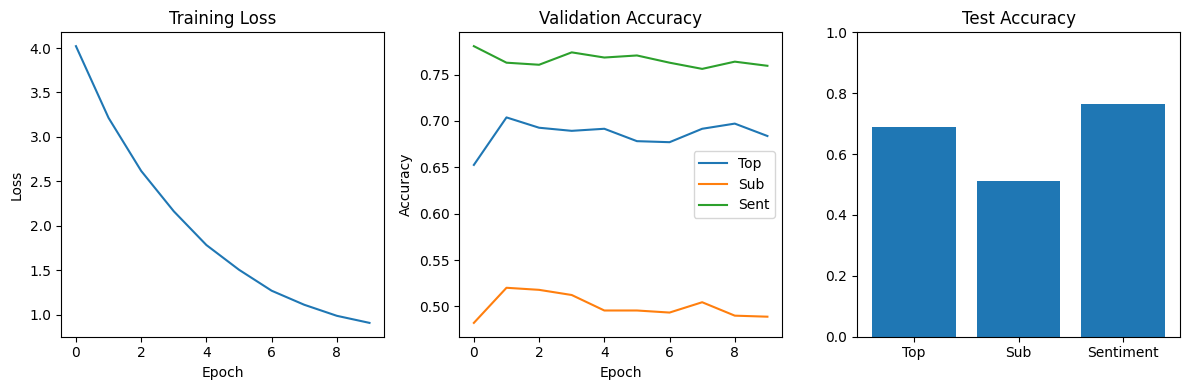

In [16]:
# Best model 로딩
model_baseline.load_state_dict(torch.load('baseline_best.pt'))

# Test
test_metrics = eval_model(model_baseline, loader_test, device)

print("\n=== Test 결과 ===")
print(f"Top Aspect Accuracy: {test_metrics['top_acc']:.4f}")
print(f"Sub Aspect Accuracy: {test_metrics['sub_acc']:.4f}")
print(f"Sentiment Accuracy: {test_metrics['sent_acc']:.4f}")

# 시각화
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(history['train_loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 3, 2)
plt.plot(history['val_top_acc'], label='Top')
plt.plot(history['val_sub_acc'], label='Sub')
plt.plot(history['val_sent_acc'], label='Sent')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
metrics_names = ['Top', 'Sub', 'Sentiment']
test_scores = [test_metrics['top_acc'], test_metrics['sub_acc'], test_metrics['sent_acc']]
plt.bar(metrics_names, test_scores)
plt.title('Test Accuracy')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()



In [17]:
# Sub Label(Index)이 어떤 Top Label(Index)에 속하는지 1/0으로 매핑하는 행렬 생성

hierarchy_matrix = torch.zeros(num_sub, num_top)

# 유니크한 조합을 뽑아서 매핑
unique_relations = df_clean[['sub_label', 'top_label']].drop_duplicates()

for _, row in unique_relations.iterrows():
    s_idx = row['sub_label']
    t_idx = row['top_label']
    hierarchy_matrix[s_idx, t_idx] = 1.0

print(f"shape={hierarchy_matrix.shape}")

shape=torch.Size([23, 6])


In [18]:
import torch.nn as nn
import torch.nn.functional as F
class HierarchicalModel(nn.Module):
    def __init__(self, num_top, num_sub, num_sent, hierarchy_matrix, dropout=0.3):
        super().__init__()

        self.encoder = AutoModel.from_pretrained('monologg/koelectra-base-v3-discriminator')
        hidden_size = self.encoder.config.hidden_size

        self.sub_classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_sub)
        )

        self.sent_classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_sent)
        )

        # [수정 1] 가중치 초기화 방식 변경 (randn -> rand)
        # 0~1 사이의 양수로 초기화하여 학습 시작을 돕습니다.
        self.register_buffer('hierarchy_mask', hierarchy_matrix)
        self.agg_weights = nn.Parameter(torch.rand(num_sub, num_top))

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.last_hidden_state[:, 0, :]

        sub_logits = self.sub_classifier(pooled)
        sent_logits = self.sent_classifier(pooled)

        # [수정 2] Top Aspect 집계 로직 강화
        sub_probs = F.softmax(sub_logits, dim=1)

        # 가중치에 Softmax를 적용하여, Top 입장에서 하위 Sub들의 합이 1이 되도록 정규화
        # (Top과 연결된 Sub들끼리의 비중을 나눔)
        masked_weights = self.agg_weights * self.hierarchy_mask

        # 0인 부분은 Softmax에서 영향을 주지 않도록 아주 작은 값으로 치환 후 Softmax (선택사항이나, 간단히 양수 유지로 해결)
        # 여기서는 간단하게 Masking 후 바로 내적하되, 학습을 위해 weights를 양수로 유지

        top_probs = torch.matmul(sub_probs, masked_weights)

        # 확률값 클리핑 (0이 되지 않도록 방지)
        top_probs = torch.clamp(top_probs, min=1e-8, max=1.0)

        return sub_logits, sent_logits, top_probs

In [19]:
def eval_model_hierarchical(model, data_loader, device):
    model.eval()

    all_top_preds, all_top_labels = [], []
    all_sub_preds, all_sub_labels = [], []
    all_sent_preds, all_sent_labels = [], []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # 예측
            sub_logits, sent_logits, top_probs = model(input_ids, attention_mask)

            # Argmax
            sub_preds = torch.argmax(sub_logits, dim=1).cpu().numpy()
            sent_preds = torch.argmax(sent_logits, dim=1).cpu().numpy()
            # Top은 이미 확률이므로 가장 높은 확률의 인덱스 선택
            top_preds = torch.argmax(top_probs, dim=1).cpu().numpy()

            all_top_preds.extend(top_preds)
            all_sub_preds.extend(sub_preds)
            all_sent_preds.extend(sent_preds)

            all_top_labels.extend(batch['top_label'].numpy())
            all_sub_labels.extend(batch['sub_label'].numpy())
            all_sent_labels.extend(batch['sent_label'].numpy())

    return {
        'top_acc': accuracy_score(all_top_labels, all_top_preds),
        'sub_acc': accuracy_score(all_sub_labels, all_sub_preds),
        'sent_acc': accuracy_score(all_sent_labels, all_sent_preds)
    }

In [20]:
model_hier = HierarchicalModel(num_top, num_sub, num_sent, hierarchy_matrix).to(device)

# Optimizer 재설정
optimizer = AdamW(model_hier.parameters(), lr=1e-4)
total_steps = len(loader_train) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, 0, len(loader_train) * EPOCHS)

# 작동테스트
print("\n=== 초기화 테스트 ===")
test_batch = next(iter(loader_train))
t_ids = test_batch['input_ids'].to(device)
t_mask = test_batch['attention_mask'].to(device)

with torch.no_grad():
    s_log, st_log, t_prob = model_hier(t_ids, t_mask)
    print(f"Sub Logits shape: {s_log.shape}")   # (32, num_sub)
    print(f"Top Probs shape:  {t_prob.shape}")  # (32, num_top)
    print(f"Top Probs Sample: {t_prob[0][:5]}") # 확률값 확인 (0~1 사이여야 함)


# 학습 함수 수정 (Loss 계산 변경)
def train_epoch_hierarchical(model, data_loader, optimizer, scheduler, device):
    model.train()
    losses = []

    # Loss 함수 정의
    # Sub, Sent는 Logit이 나오므로 CrossEntropyLoss 사용
    criterion_ce = nn.CrossEntropyLoss()
    # Top은 Probability가 나오므로 NLLLoss 사용 (입력에 log를 취해야 함)
    criterion_nll = nn.NLLLoss()

    progress_bar = tqdm(data_loader, desc='Training (Hierarchical)')

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        top_labels = batch['top_label'].to(device)
        sub_labels = batch['sub_label'].to(device)
        sent_labels = batch['sent_label'].to(device)

        # Forward
        sub_logits, sent_logits, top_probs = model(input_ids, attention_mask)

        # Loss Calculation
        loss_sub = criterion_ce(sub_logits, sub_labels)
        loss_sent = criterion_ce(sent_logits, sent_labels)
        loss_top = criterion_nll(torch.log(top_probs), top_labels)

        loss = loss_sub * 2  + loss_sent + loss_top

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        losses.append(loss.item())
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}', 'sub_l': f'{loss_sub.item():.2f}', 'top_l': f'{loss_top.item():.2f}'})

    return np.mean(losses)


=== 초기화 테스트 ===
Sub Logits shape: torch.Size([32, 23])
Top Probs shape:  torch.Size([32, 6])
Top Probs Sample: tensor([0.0986, 0.0463, 0.1434, 0.1122, 0.0871], device='cuda:0')


In [21]:
import time

model_hier = HierarchicalModel(num_top, num_sub, num_sent, hierarchy_matrix).to(device)

EPOCHS = 10
LEARNING_RATE = 1e-4

optimizer = AdamW(model_hier.parameters(), lr=LEARNING_RATE)

total_steps = len(loader_train) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

history = {
    'train_loss': [],
    'val_top_acc': [],
    'val_sub_acc': [],
    'val_sent_acc': []
}
best_val_acc = 0.0

print("=" * 60)
print("Hierarchical Model 학습 시작")
print(f"Device: {device}")
print("=" * 60)


for epoch in range(EPOCHS):
    start_time = time.time()

    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    train_loss = train_epoch_hierarchical(
        model_hier,
        loader_train,
        optimizer,
        scheduler,
        device
    )

    val_metrics = eval_model_hierarchical(model_hier, loader_val, device)

    history['train_loss'].append(train_loss)
    history['val_top_acc'].append(val_metrics['top_acc'])
    history['val_sub_acc'].append(val_metrics['sub_acc'])
    history['val_sent_acc'].append(val_metrics['sent_acc'])

    elapsed = time.time() - start_time

    print(f"  > Train Loss: {train_loss:.4f} | Time: {elapsed:.0f}s")
    print(f"  > Valid Acc  : Top={val_metrics['top_acc']:.2%} | Sub={val_metrics['sub_acc']:.2%} | Sent={val_metrics['sent_acc']:.2%}")

    # Best Model 저장 (Top Accuracy 기준)
    if val_metrics['top_acc'] > best_val_acc:
        best_val_acc = val_metrics['top_acc']
        torch.save(model_hier.state_dict(), 'hierarchical_best.pt')
        print(f"  ★ Best Model Saved! ({best_val_acc:.2%})")

print("\n" + "=" * 60)
print(f"학습 종료! 최고 Validation Top Acc: {best_val_acc:.2%}")
print("=" * 60)

Hierarchical Model 학습 시작
Device: cuda

Epoch 1/10


Training (Hierarchical):   0%|          | 0/225 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

  > Train Loss: 6.9624 | Time: 150s
  > Valid Acc  : Top=65.59% | Sub=49.33% | Sent=70.60%
  ★ Best Model Saved! (65.59%)

Epoch 2/10


Training (Hierarchical):   0%|          | 0/225 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

  > Train Loss: 5.7730 | Time: 150s
  > Valid Acc  : Top=70.27% | Sub=50.78% | Sent=72.16%
  ★ Best Model Saved! (70.27%)

Epoch 3/10


Training (Hierarchical):   0%|          | 0/225 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

  > Train Loss: 5.3270 | Time: 149s
  > Valid Acc  : Top=57.68% | Sub=36.41% | Sent=56.68%

Epoch 4/10


Training (Hierarchical):   0%|          | 0/225 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

  > Train Loss: 7.4692 | Time: 149s
  > Valid Acc  : Top=57.57% | Sub=36.75% | Sent=56.90%

Epoch 5/10


Training (Hierarchical):   0%|          | 0/225 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

  > Train Loss: 7.4245 | Time: 149s
  > Valid Acc  : Top=57.57% | Sub=36.75% | Sent=56.90%

Epoch 6/10


Training (Hierarchical):   0%|          | 0/225 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

  > Train Loss: 7.3835 | Time: 149s
  > Valid Acc  : Top=57.57% | Sub=36.75% | Sent=56.90%

Epoch 7/10


Training (Hierarchical):   0%|          | 0/225 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

  > Train Loss: 7.3661 | Time: 149s
  > Valid Acc  : Top=57.57% | Sub=36.75% | Sent=56.90%

Epoch 8/10


Training (Hierarchical):   0%|          | 0/225 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

  > Train Loss: 7.3578 | Time: 149s
  > Valid Acc  : Top=57.57% | Sub=36.75% | Sent=56.90%

Epoch 9/10


Training (Hierarchical):   0%|          | 0/225 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

  > Train Loss: 7.3381 | Time: 149s
  > Valid Acc  : Top=57.57% | Sub=36.75% | Sent=56.90%

Epoch 10/10


Training (Hierarchical):   0%|          | 0/225 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

  > Train Loss: 7.3294 | Time: 149s
  > Valid Acc  : Top=57.57% | Sub=36.75% | Sent=56.90%

학습 종료! 최고 Validation Top Acc: 70.27%


In [24]:
model_hier.load_state_dict(torch.load('hierarchical_best.pt'))
model_hier.eval()

# 2. 가중치 추출
# 학습된 파라미터 가져오기
weights = model_hier.agg_weights.data
mask = model_hier.hierarchy_mask

# 마스킹 적용 (연결 안 된 부분은 0으로)
masked_weights = weights * mask

# 보기 좋게 정규화 (Top Aspect 별로 하위 항목 합이 100%가 되도록)
# dim=0은 Sub Aspect 축입니다. 각 Top Aspect 컬럼에 대해 Softmax/Normalize
# 여기서는 직관적인 비율 확인을 위해 단순 비율로 계산합니다.
normalized_weights = masked_weights / (masked_weights.sum(dim=0, keepdim=True) + 1e-9)

print("\n=== 상위 측면별 하위 요소 기여도 분석 (전체) ===")

# Top Aspect 별로 순회하며 출력
for top_idx, top_name in top_mapping.items():
    print(f"\n[ Top Aspect: {top_name} ]")

    # 해당 Top Aspect에 속하는 Sub Aspect 찾기
    sub_indices = torch.nonzero(mask[:, top_idx]).flatten()

    if len(sub_indices) == 0:
        continue

    # 해당 Sub Aspect들의 가중치 가져오기
    sub_contributions = []
    for sub_idx in sub_indices:
        w = normalized_weights[sub_idx, top_idx].item()
        sub_name = sub_mapping[sub_idx.item()]
        sub_contributions.append((sub_name, w))

    # 기여도 높은 순으로 정렬
    sub_contributions.sort(key=lambda x: x[1], reverse=True)

    # 출력
    for name, weight in sub_contributions:
        print(f"  - {name:<20} : {weight*100:.2f}%")


=== 상위 측면별 하위 요소 기여도 분석 (전체) ===

[ Top Aspect: AUDIOVISUAL ]
  - AV_GRAPHICS          : 42.32%
  - AV_UI_FEEL           : 31.42%
  - AV_SOUND             : 26.26%

[ Top Aspect: ECONOMY_PROGRESSION ]
  - ECO_REWARD           : 43.26%
  - ECO_PROGRESSION      : 29.86%
  - ECO_MONETIZATION     : 26.89%

[ Top Aspect: GAMEPLAY ]
  - SYS_DIFFICULTY       : 26.40%
  - GP_COMBAT            : 24.77%
  - GP_CONTROL           : 22.59%
  - GP_FUN               : 11.04%
  - GP_CONTENT           : 10.87%
  - SYS_BALANCE          : 4.33%

[ Top Aspect: MULTI_COMMUNITY ]
  - COMMUNITY_BEHAVIOR   : 34.40%
  - MULTI_SOCIAL         : 32.44%
  - MULTI_MATCHING       : 26.16%
  - MULTI_FAIRNESS       : 7.00%

[ Top Aspect: SYSTEM_BALANCE ]
  - SYS_BALANCE          : 43.56%
  - SYS_RULE             : 27.98%
  - SYS_AI               : 22.17%
  - SYS_DIFFICULTY       : 6.29%

[ Top Aspect: TECHNICAL ]
  - TECH_LOCALIZATION    : 58.15%
  - TECH_PERFORMANCE     : 21.61%
  - TECH_NET             : 9.16%
  - 

In [26]:
# 모델 저장

import os
import shutil

files_to_save = [
    'baseline_best.pt',
    'hierarchical_best.pt',
]

destination_path = '/content/drive/MyDrive'
os.makedirs(destination_path, exist_ok=True)

for file_name in files_to_save:
    if os.path.exists(file_name):
        try:
            shutil.copy(file_name, destination_path)
            print(f'{file_name} 성공')
        except Exception as e:
            print(f'{file_name} 실패')
    else:
        print(f"{file_name} 파일을 찾을 수 없음")

baseline_best.pt 성공
hierarchical_best.pt 성공


## 게임(app_id)별 분석